Data Loading Phase

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df = pd.read_csv("dataset.csv")
print(df.isna().sum())
print(df.head())

age         51
sex          0
cp           0
trestbps    51
chol        13
fbs          0
restecg      0
thalach     17
exang        0
oldpeak      1
slope        0
ca          51
thal        51
target       0
dtype: int64
    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1  53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2  70.0    1   0     145.0  174.0    0        1    125.0      1      2.6   
3  61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
4  62.0    0   0     138.0  294.0    1        1    106.0      0      1.9   

   slope   ca  thal  target  
0      2  2.0   3.0       0  
1      0  0.0   3.0       0  
2      0  0.0   3.0       0  
3      2  1.0   3.0       0  
4      1  NaN   NaN       0  


Handling Missing and Noisy Values

KNN Imputation to fill out missing values:
KNN imputation (K-Nearest Neighbors imputation) is a method to fill in missing values in your dataset by looking at the most similar (nearest) rows in the data.
Instead of replacing missing values with a simple mean or median, KNN imputation uses information from other data points that are most similar to the one with missing data.

IQR method to detect outliers:
The Interquartile Range (IQR) measures the spread of the middle 50% of a dataset.
It’s computed as:

IQR=Q3−Q1
IQR=Q3−Q1

where:
Q1 = 25th percentile (the value below which 25% of data fall)
Q3 = 75th percentile (the value below which 75% of data fall)

So, the IQR tells you how spread out the central data is, ignoring extremes.

In [ ]:
def knn_impute_weighted(df, k=3, epsilon=1e-5):
    df_imputed = df.copy()
    data = df.values

    for i in range(len(data)):
        row = data[i]
        if np.any(np.isnan(row)):
            distances = []
            for j in range(len(data)):
                if i == j:
                    continue
                other = data[j]
                mask = ~np.isnan(row) & ~np.isnan(other)
                if np.sum(mask) == 0:
                    continue
                dist = np.sqrt(np.sum((row[mask] - other[mask]) ** 2))
                distances.append((dist, j))

            distances.sort(key=lambda x: x[0])
            neighbors = distances[:k]

            for col in range(data.shape[1]):
                if np.isnan(row[col]):
                    vals, weights = [], []
                    for dist, j in neighbors:
                        val = data[j, col]
                        if not np.isnan(val):
                            w = 1.0 / (dist + epsilon)
                            vals.append(val)
                            weights.append(w)
                    if vals:
                        weighted_avg = np.average(vals, weights=weights)
                        df_imputed.iat[i, col] = weighted_avg
    return df_imputed

def remove_outliers_iqr(df, exclude_cols=[]):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in exclude_cols:
            continue

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        before = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after = len(df_clean)

        print(f"{col}: removed {before - after} outliers")

    return df_clean

def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    df_filled = df.copy()
    
    for column in df_filled.columns:
        if df_filled[column].dtype in [np.float64, np.int64]:
            # numeric: mean
            mean_value = df_filled[column].mean()
            df_filled[column].fillna(mean_value, inplace=True)
        else:
            # categorical: mode
            mode_value = df_filled[column].mode()
            if not mode_value.empty:
                df_filled[column].fillna(mode_value[0], inplace=True)
    
    return df_filled

age: removed 0 outliers
cp: removed 0 outliers
trestbps: removed 0 outliers
chol: removed 3 outliers
restecg: removed 0 outliers
thalach: removed 0 outliers
oldpeak: removed 0 outliers
slope: removed 0 outliers
ca: removed 0 outliers
thal: removed 0 outliers
Missing values after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


C:\Users\RayanTech\AppData\Local\Temp\ipykernel_18760\89572815.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled[column].fillna(mean_value, inplace=True)


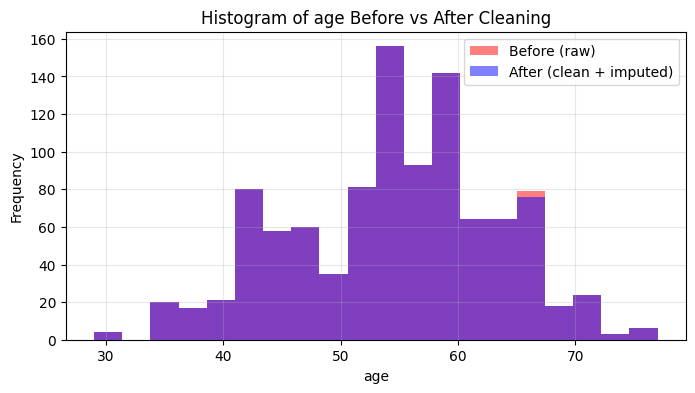

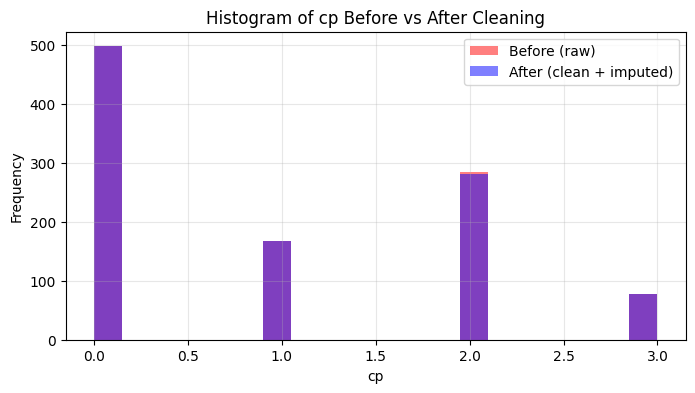

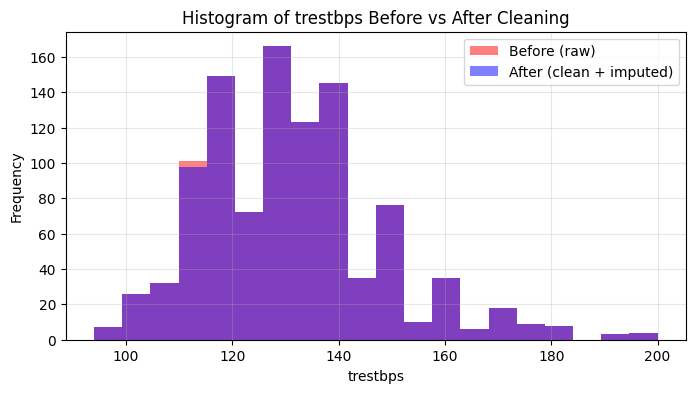

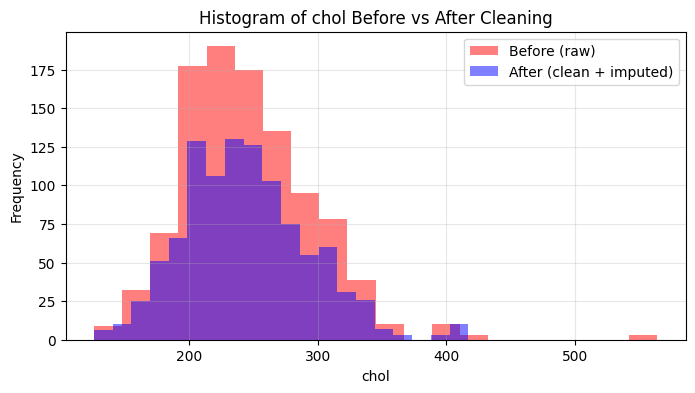

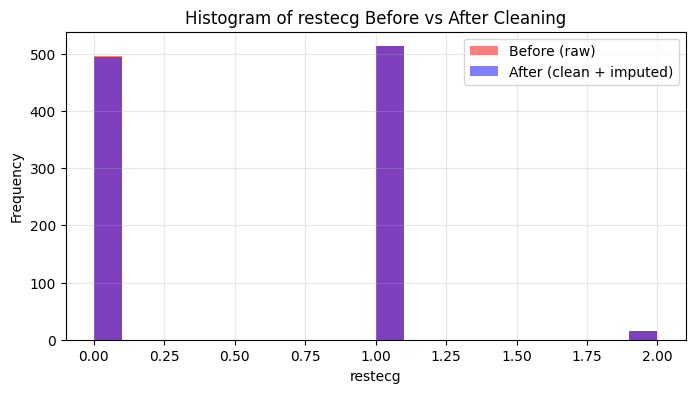

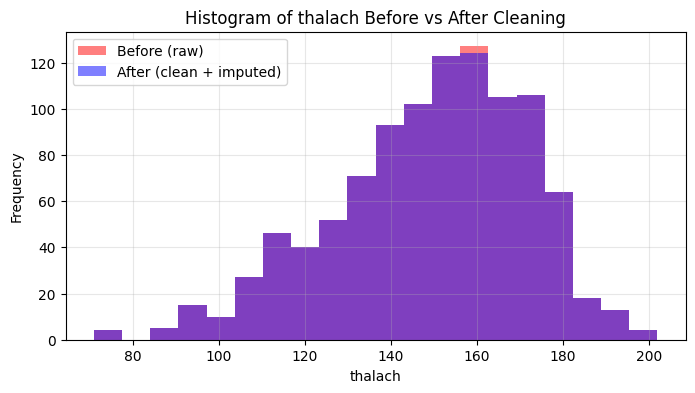

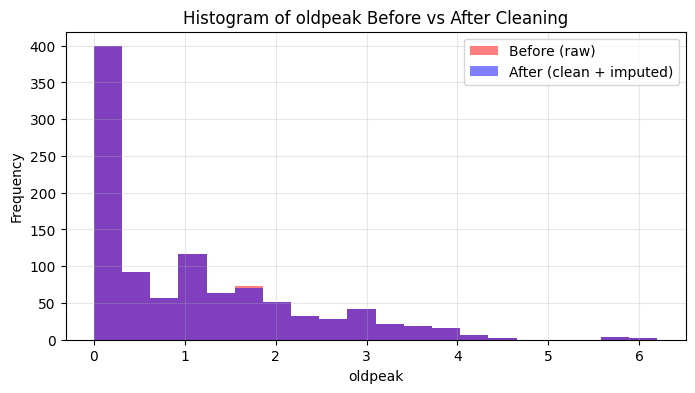

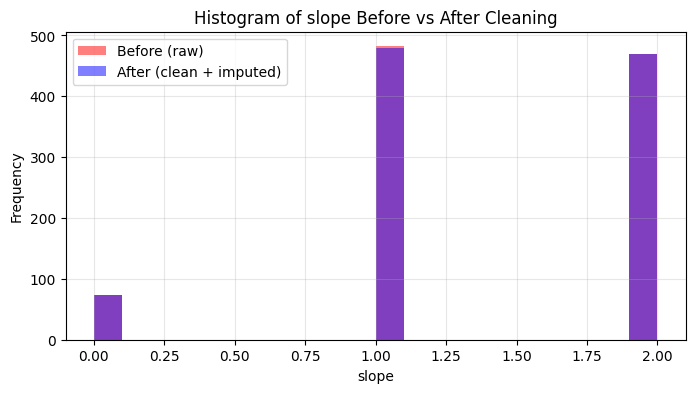

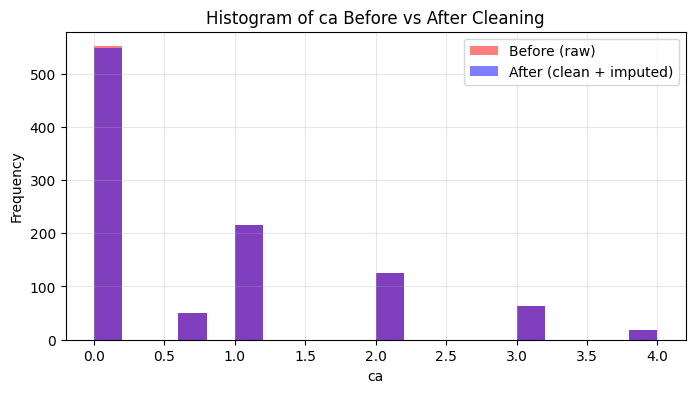

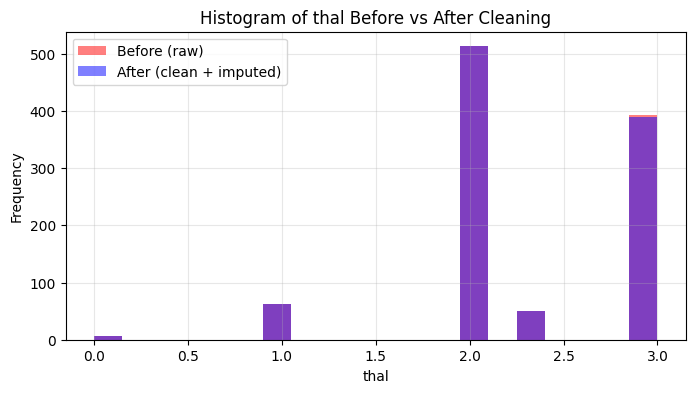

In [106]:
exclude_cols = ['target', 'sex', 'fbs', 'exang']
df_clean = remove_outliers_iqr(df, exclude_cols=exclude_cols)
df_imputed = fill_missing_values(df_clean)

print("Missing values after imputation:")
print(df_imputed.isna().sum())

numeric_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.float64, np.int64]]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col].dropna(), bins=20, alpha=0.5, label='Before (raw)', color='red')
    plt.hist(df_imputed[col].dropna(), bins=20, alpha=0.5, label='After (clean + imputed)', color='blue')
    plt.title(f'Histogram of {col} Before vs After Cleaning')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

as can be seen from the histograms before and after the preprocessing phase, the attributes with outliers showed a larger difference in their histograms. The attributes having the largest number of outliers are chol and thalach and after the cleaning, their histogram became a little bit more like the normal distribution which is totally desired. The rest of attributes did not contain many outliers and therefore, their distribution did not change much.

Normalization

I applied a z-score method to normalize numerical attributes of the dataset.

In [107]:
df = df_imputed
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
df_scaled[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
print(df_scaled.describe())

                age           sex            cp      trestbps          chol  \
count  1.022000e+03  1.022000e+03  1.022000e+03  1.022000e+03  1.022000e+03   
mean  -8.899165e-16 -5.561978e-17  3.476236e-17  1.025490e-16 -4.866731e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.889991e+00 -1.518284e+00 -9.123714e-01 -2.198728e+00 -2.460638e+00   
25%   -7.312043e-01 -1.518284e+00 -9.123714e-01 -6.764516e-01 -7.032757e-01   
50%    6.413810e-02  6.579939e-01  5.892399e-02 -9.096085e-02 -1.037049e-01   
75%    6.322398e-01  6.579939e-01  1.030219e+00  4.945299e-01  5.992402e-01   
max    2.563786e+00  6.579939e-01  2.001515e+00  4.007474e+00  3.555744e+00   

                fbs       restecg       thalach         exang       oldpeak  \
count  1.022000e+03  1.022000e+03  1.022000e+03  1.022000e+03  1.022000e+03   
mean   2.085742e-17  2.780989e-17 -1.484353e-15  3.650048e-17 -1.460019e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

Exploratory Data Analysis (EDA)

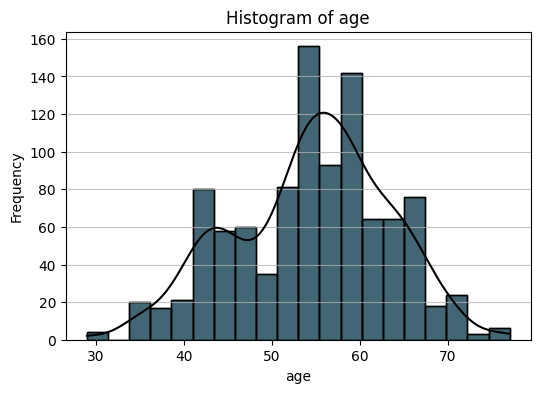

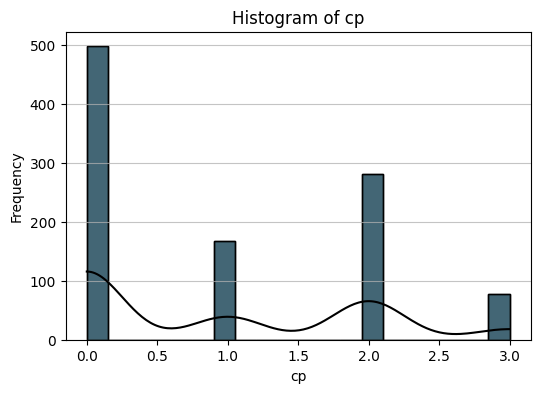

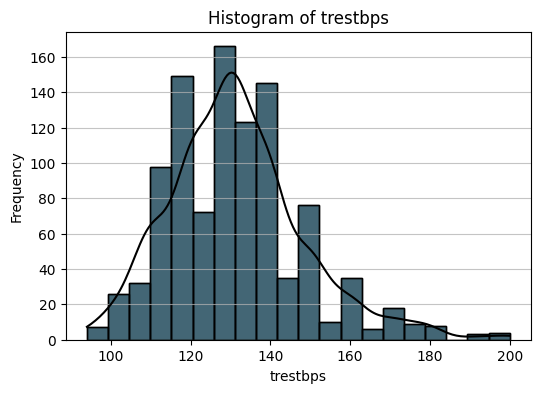

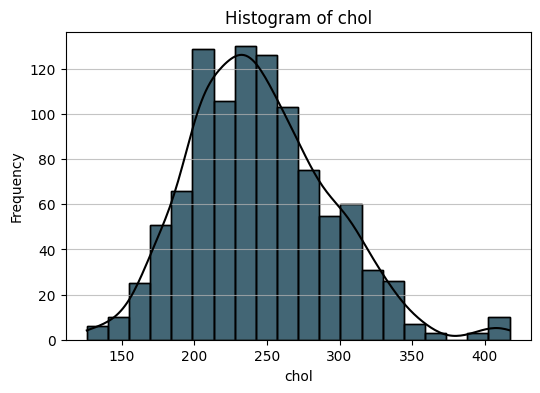

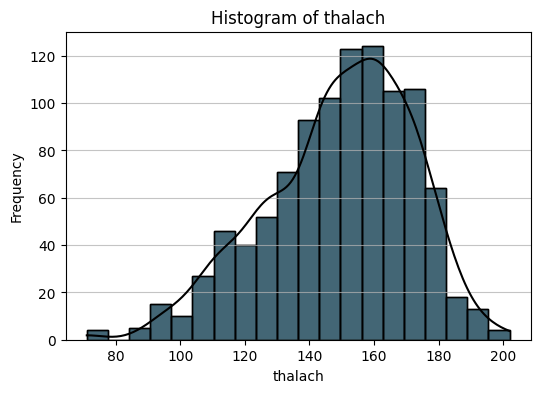

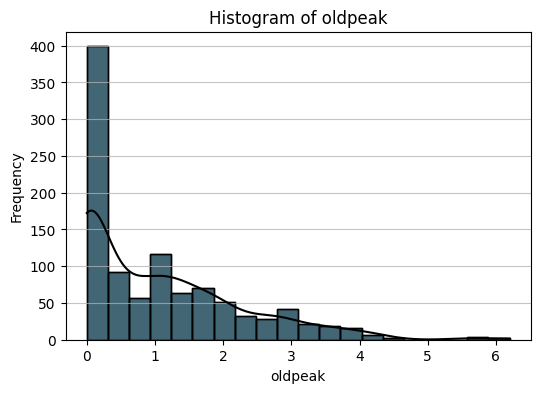

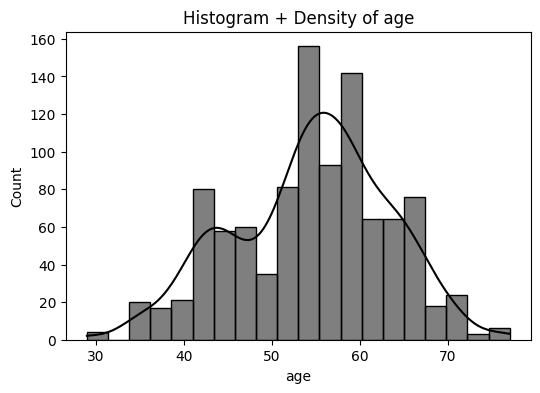

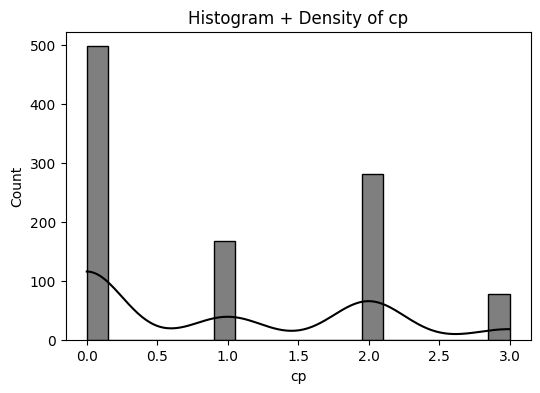

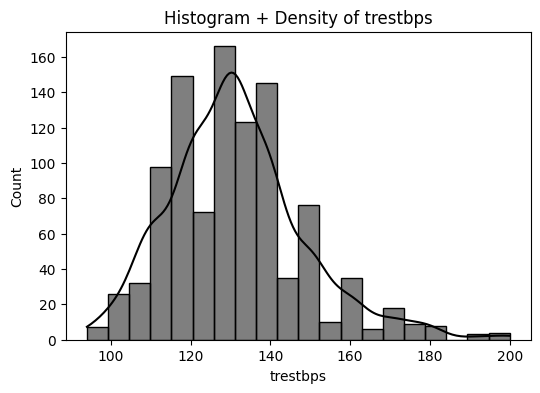

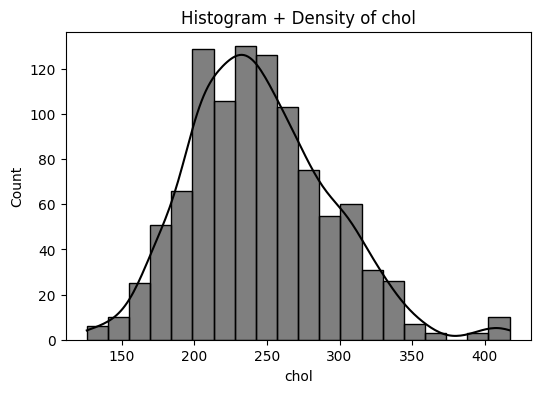

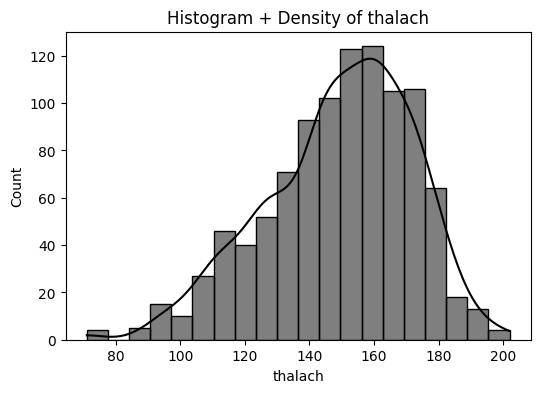

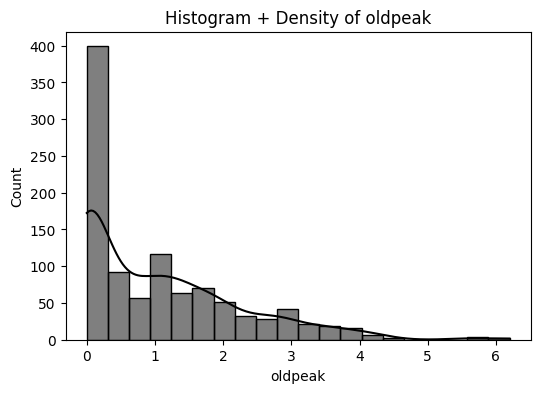

In [108]:

exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram + Density of {col}')
    plt.show()

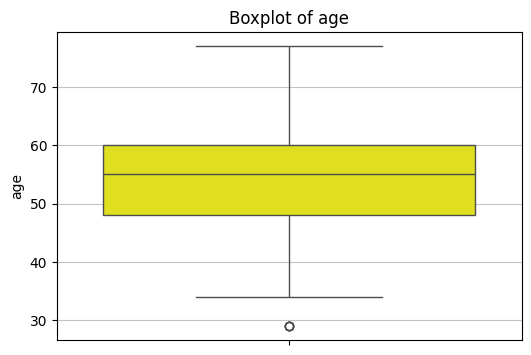

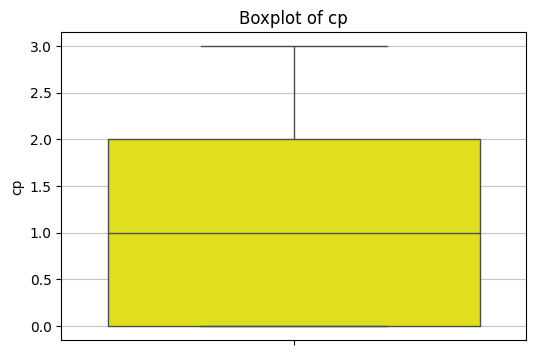

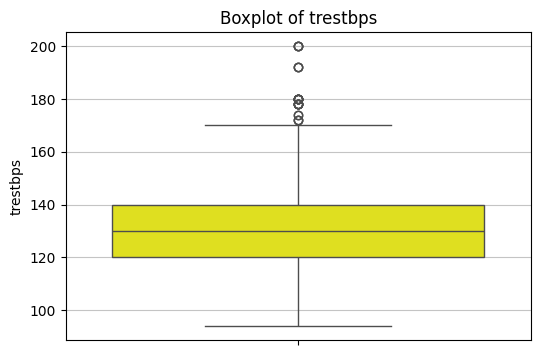

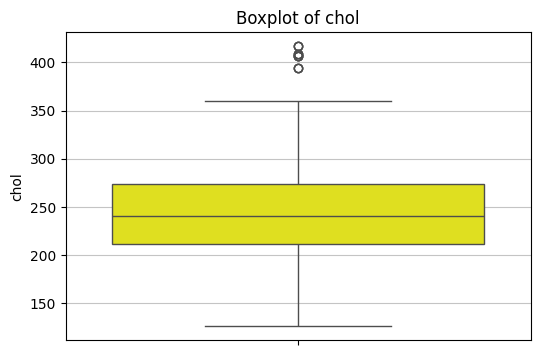

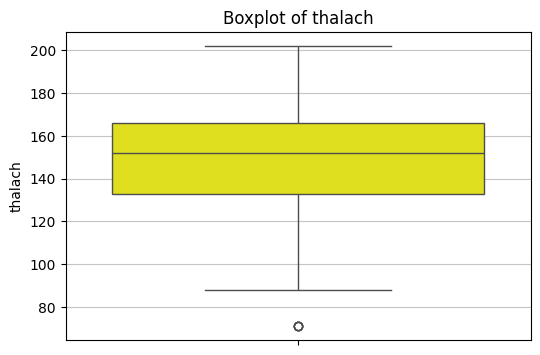

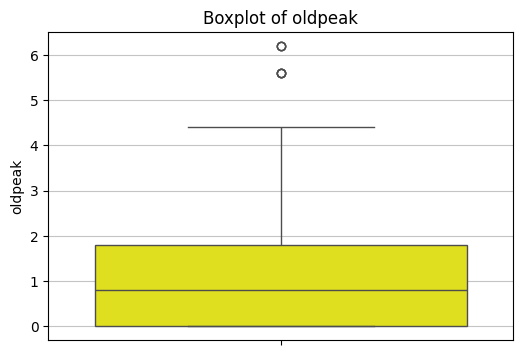

In [109]:
exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col], color='yellow')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

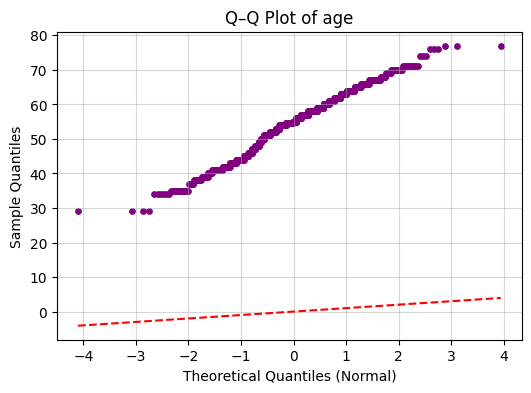

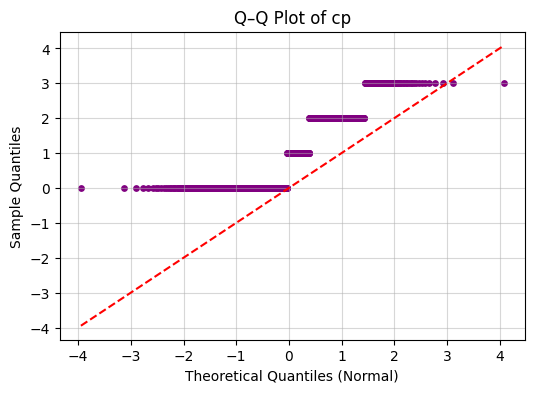

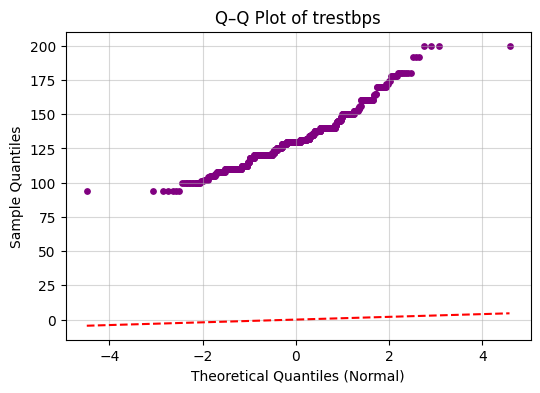

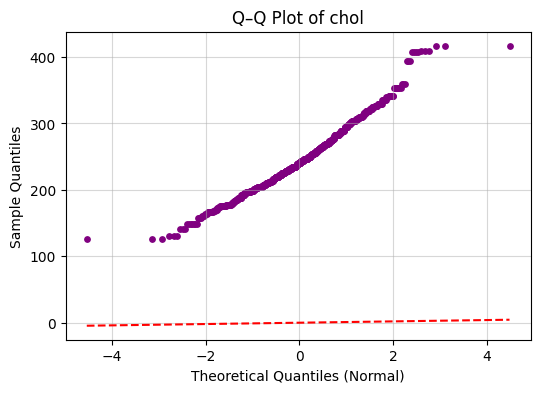

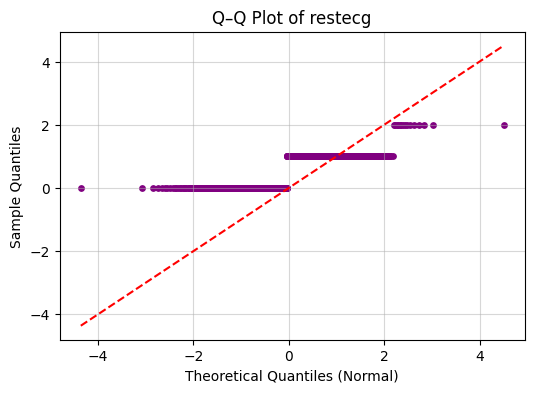

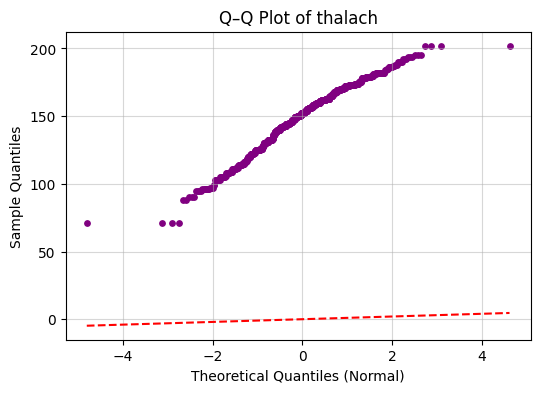

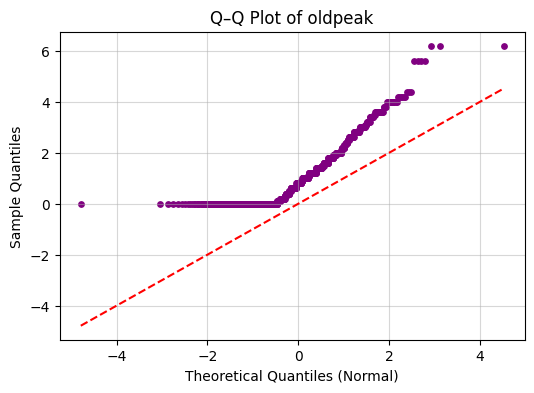

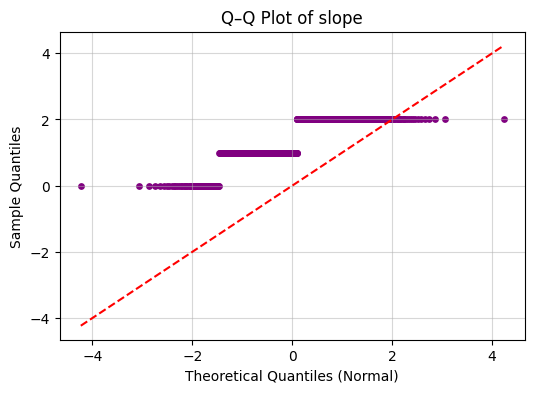

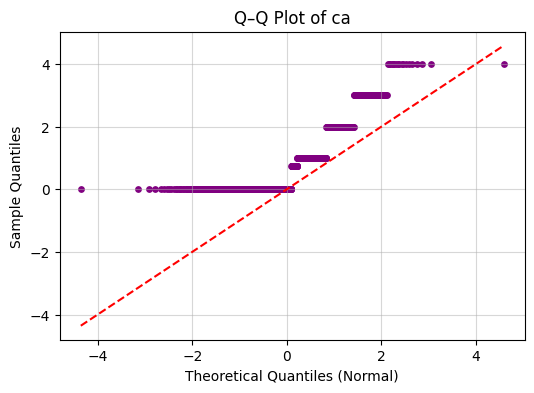

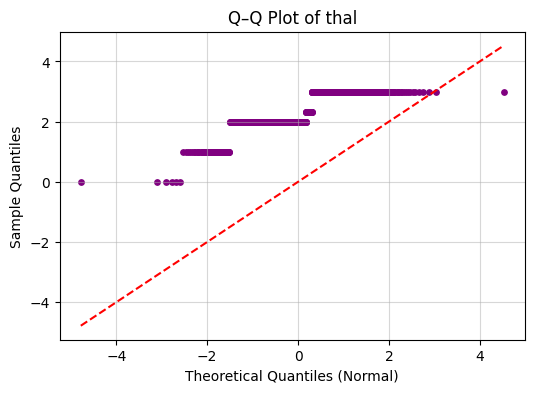

In [110]:
exclude_cols = ['target', 'exang', 'fbs', 'sex']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols]
def normal_quantiles(size):
    return np.quantile(np.random.normal(0, 1, 100000), np.linspace(0, 1, size))

for col in numeric_cols:
    data = df[col].dropna().values
    data_sorted = np.sort(data)
    theoretical = normal_quantiles(len(data_sorted))

    plt.figure(figsize=(6, 4))
    plt.scatter(theoretical, data_sorted, color='purple', s=15)
    plt.plot(theoretical, theoretical, color='red', linestyle='--')
    plt.title(f'Q–Q Plot of {col}')
    plt.xlabel('Theoretical Quantiles (Normal)')
    plt.ylabel('Sample Quantiles')
    plt.grid(True, alpha=0.5)
    plt.show()

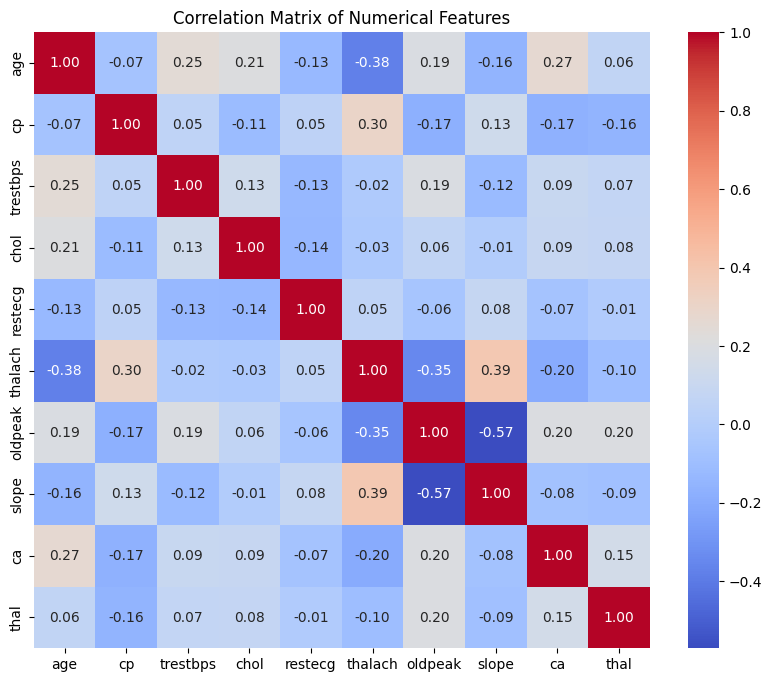

In [111]:
exclude_cols = ['target', 'exang', 'fbs', 'sex']

numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Most features are reasonably independent, which is good for KNN — each contributes differently to distance calculations.
However, a tiny bit of correlation can be seen between slope (Slope of the peak exercise ST segment (0–2)) and oldpeak (ST depression induced by exercise relative to rest).

Train and Test the Model

In [112]:
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy()

np.random.seed(42)
indices = np.arange(len(df))
np.random.shuffle(indices)

train_size = int(0.8 * len(df))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 817
Test size: 205


The dissimilarity is computed using the Eucleadian distance.

In [113]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict_weighted(X_train, y_train, X_test, k=5):
    y_pred = []
    for test_point in X_test:
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        nn_indices = distances.argsort()[:k]
        nn_labels = y_train[nn_indices]
        nn_distances = distances[nn_indices]
        weights = 1 / (nn_distances + 1e-5)
        label_weights = {}
        for label, w in zip(nn_labels, weights):
            label_weights[label] = label_weights.get(label, 0) + w
        y_pred.append(max(label_weights, key=label_weights.get))
    return np.array(y_pred)

best_k = 1
best_acc = 0
for k in range(1, 21, 2):
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc = np.mean(y_pred == y_test)
    print(f"k={k}, accuracy={acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k
print("Best k:", best_k, "with accuracy:", best_acc)


k=1, accuracy=0.961
k=3, accuracy=0.956
k=5, accuracy=0.956
k=7, accuracy=0.971
k=9, accuracy=0.976
k=11, accuracy=0.980
k=13, accuracy=0.980
k=15, accuracy=0.980
k=17, accuracy=0.985
k=19, accuracy=0.971
Best k: 17 with accuracy: 0.9853658536585366


k=1, accuracy=0.961
k=3, accuracy=0.956
k=5, accuracy=0.956
k=7, accuracy=0.971
k=9, accuracy=0.976
k=11, accuracy=0.980
k=13, accuracy=0.980
k=15, accuracy=0.980
k=17, accuracy=0.985
k=19, accuracy=0.971
Best k: 17 with accuracy: 0.9853658536585366


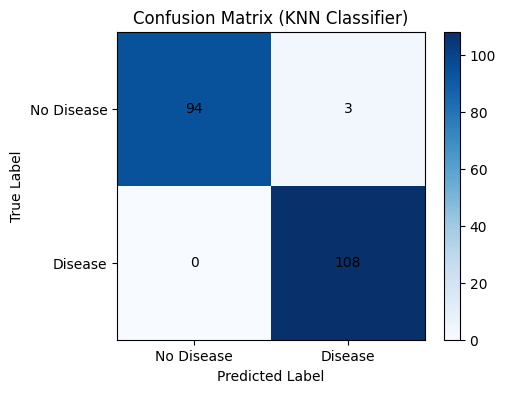

In [ ]:

def plot_confusion_matrix(y_true, y_pred, labels=['0', '1']):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t)][int(p)] += 1

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap='Blues')

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (KNN Classifier)')
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.colorbar(im)
    plt.show()

def compute_metrics(y_true, y_pred):
    """
    Works for binary classification (labels 0 and 1)
    Returns accuracy, precision, recall, f1-score
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy, precision, recall, f1

best_k = 1
best_acc = 0
best_y_pred = None

for k in range(1, 21, 2):
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc = np.mean(y_pred == y_test)
    print(f"k={k}, accuracy={acc:.3f}")

    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_y_pred = y_pred

print("Best k:", best_k, "with accuracy:", best_acc)
plot_confusion_matrix(y_true=y_test, y_pred=best_y_pred, labels=['No Disease', 'Disease'])

Apply K-Fold Cross-Validation

In [115]:
def k_fold_cross_validation(X, y, k_neighbors=5, n_splits=5, weighted=True):
    """
    Perform K-Fold CV for KNN
    X: features (numpy array)
    y: labels (numpy array)
    k_neighbors: number of neighbors for KNN
    n_splits: number of folds
    weighted: whether to use weighted KNN
    Returns: average metrics across folds
    """
    fold_size = len(X) // n_splits
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    accuracies, precisions, recalls, f1s = [], [], [], []

    for i in range(n_splits):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        if weighted:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)
        else:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)

        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    return {
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1-score': np.mean(f1s)
    }

k_values = range(1, 21, 2)
rows = []

for k in k_values:
    metrics = k_fold_cross_validation(X_train, y_train, k_neighbors=k, n_splits=5)
    rows.append({
        'k': k,
        'Accuracy': round(metrics['Accuracy'], 3),
        'Precision': round(metrics['Precision'], 3),
        'Recall': round(metrics['Recall'], 3),
        'F1-score': round(metrics['F1-score'], 3)
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

    k  Accuracy  Precision  Recall  F1-score
0   1     0.942      0.946   0.940     0.943
1   3     0.928      0.915   0.945     0.929
2   5     0.939      0.932   0.946     0.938
3   7     0.941      0.936   0.949     0.942
4   9     0.923      0.923   0.929     0.924
5  11     0.929      0.932   0.932     0.930
6  13     0.934      0.927   0.943     0.935
7  15     0.920      0.919   0.925     0.922
8  17     0.939      0.942   0.939     0.940
9  19     0.935      0.931   0.945     0.937


The highest accuracy occured in k=7, and after 7, it slightly decreased. The same result observed in the elbow method, the peak of the graph is at k = 7, therefore, the optimum k for our case is 7.

Elbow Method

k=1, CV Error=0.047
k=3, CV Error=0.035
k=5, CV Error=0.046
k=7, CV Error=0.052
k=9, CV Error=0.045
k=11, CV Error=0.041
k=13, CV Error=0.039
k=15, CV Error=0.034
k=17, CV Error=0.051
k=19, CV Error=0.033


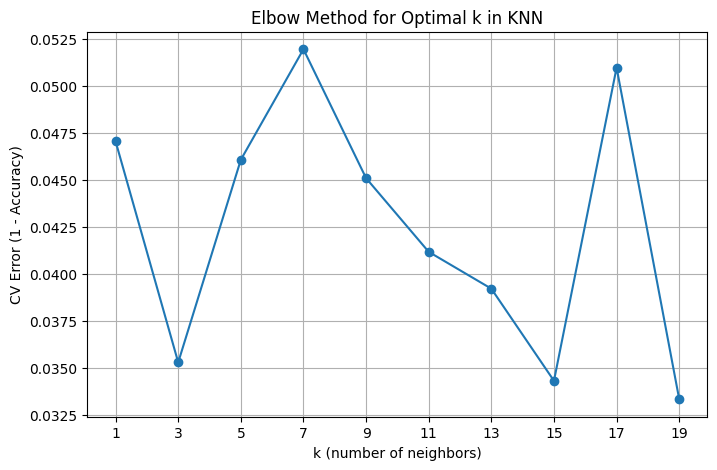

In [116]:
def knn_error_for_k(X, y, k_values, n_splits=5, weighted=True):
    errors = []
    for k in k_values:
        metrics = k_fold_cross_validation(X, y, k_neighbors=k, n_splits=n_splits, weighted=weighted)
        error = 1 - metrics['Accuracy']
        errors.append(error)
        print(f"k={k}, CV Error={error:.3f}")
    return errors

k_values = range(1, 21, 2)
cv_errors = knn_error_for_k(X, y, k_values, n_splits=5)

plt.figure(figsize=(8,5))
plt.plot(k_values, cv_errors, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('CV Error (1 - Accuracy)')
plt.title('Elbow Method for Optimal k in KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()